2.0 / Toyota Mirai
MPG is:  1369    81.682986
Name: mpgge, dtype: float64


<IPython.core.display.Javascript object>


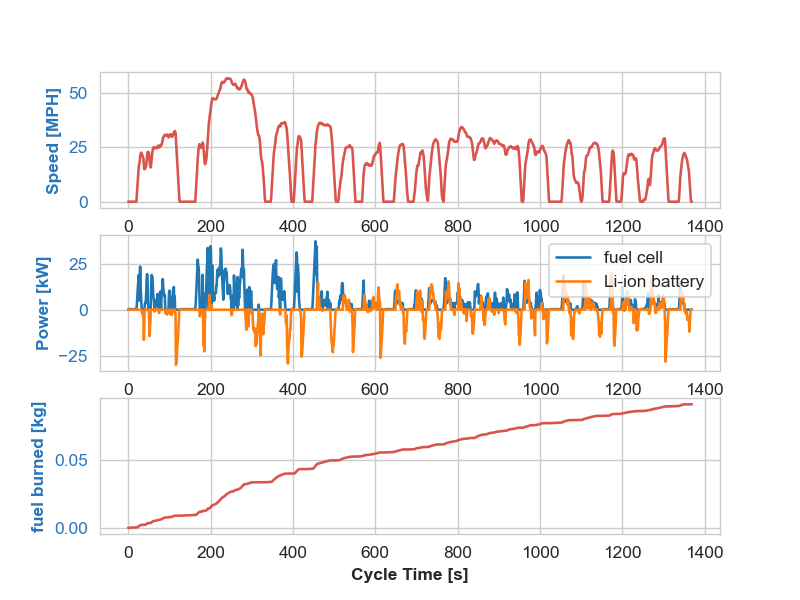

In [3]:
import sys
sys.path.append('../src')
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib notebook
import FASTSim_BX_v2_ECMS_rulebase


##################################################################################
# Individual Drive Cycle
# Load Drive Cycle
# Default (UDDS, US06, HWFET) cycles can be loaded from the ../cycles directory, or custom cycles can be specified in the same format. The expected format is a dictionary with the following keys:
# ['cycGrade', 'cycMps', 'cycSecs', 'cycRoadType']
#     cycGrade = Road grade [%/100]
#     cycMps = Vehicle speed [meters per second]
#     cycSecs = Relative time in the cycles [seconds]
#     cycRoadType = Indicator as to whether or not there is a wireless charging capability from the road to vehicle
# There is no limit to the length of a drive cycle that can be provided as an input to FASTSim.
cyc = FASTSim_BX_v2_ECMS_rulebase.get_standard_cycle("UDDS")


##################################################################################
# choose Powertrain Model ########################################################
##################################################################################
# A vehicle database in CSV format is required to be in the working directory where FASTSim is running 
# (i.e. the same directory as this notebook). The "get_veh" function selects the appropriate vehicle
# attributes from the database and contructs the powertrain model (engine efficiency map, etc.). 
# An integer value corresponds to each vehicle in the database. To add a new vehicle, simply 
# populate a new row to the vehicle database CSV.

### Toyota Mirai fuel cell
veh_num=24

### Hyndai Tucson fuel cell
# veh_num=23


veh = FASTSim_BX_v2_ECMS_rulebase.get_veh(veh_num)
print(veh['vehPtType'],'/',veh['name'])


########################################################################################
# choose baseline EMS strategy #########################################################
########################################################################################
veh['EMS']='ECMS'
# veh['EMS']='rule'


########################################################################################
# run the simulation
# Run FASTSim
# The "sim_drive" function takes the drive cycle and vehicle models defined above as inputs. The output is a dictionary of time series and scalar values described the simulation results. Typically of interest is the "gge" key, which is an array of time series energy consumption data at each time step in the drive cycle. Additionally, to add a result from the simulator to the output dictionary, a user can modify the sim_drive_sub function source code to include the desired field.
# If running FASTSim in batch over many drive cycles, the output from "sim_drive" can be written to files or database for batch post-processing.
output = FASTSim_BX_v2_ECMS_rulebase.sim_drive(cyc, veh)
   
    
########################################################################################
# Results
df = pd.DataFrame.from_dict(output)[['soc','fcKwInAch','fcKwOutAch','essKwOutAch',\
                                     'mcMechKwOutAch','auxInKw','mcElecKwInAch','mpgge',\
                                     'transKwInAch','mcMechKw4ForcedFc','canPowerAllElectrically',\
                                     'fuelKg','fuelKgAch']]
df['speed'] = cyc['cycMps'] * 2.23694  # Convert mps to mph
print('MPG is: ',df['mpgge'][-1:])


########################################################################################
#  plot
ax = plt.subplot(3,1,1)
speed_line = df.speed.plot(color='xkcd:pale red', ax=ax, label='Speed')
ax.set_ylabel('Speed [MPH]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')

ax = plt.subplot(3,1,2)
line1 = df.fcKwOutAch.plot(ax=ax, label='kW')
line2 = df.essKwOutAch.plot(ax=ax, label='kW')
ax.set_ylabel('Power [kW]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')
ax.legend(['fuel cell','Li-ion battery'])

ax11 = plt.subplot(3,1,3)
speed_line = df.fuelKgAch.plot(color='xkcd:pale red', ax=ax11, label='Speed')
ax11.set_xlabel('Cycle Time [s]', weight='bold')
ax11.set_ylabel('fuel burned [kg]', weight='bold', color='xkcd:bluish')
ax11.tick_params('y', colors='xkcd:bluish')